In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import ioh
import itertools
from IOHexperimenter import IOH_function
import matplotlib


sns.set_style("whitegrid")
sns.set_palette("colorblind")
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

best_selector = "DS_Catch22_R(A)_0.8"

orig_inst_set = "../instance_dac/instance_sets/cmaes/seplow/train.csv"
test_inst_set = "../instance_dac/instance_sets/cmaes/seplow/test.csv"
path = Path("../data/instance_sets/selected/generated/CMA-ES/seplow_train/Train")
print(path.resolve())

selected_inst_set = Path("../data/instance_sets/selected/generated/CMA-ES/seplow_train/Train/DS/Catch22/RA/0.8")
fnames = list(selected_inst_set.glob("**/*.csv"))

paths = [
    ("full", "train", [orig_inst_set]),
    ("full", "test", [test_inst_set]),
    ("selector", "train", fnames),
]

D = []
for n, mode, p in paths:
    for path in p:
        with open(path, "r") as fh:
                for line in itertools.islice(fh, 1, None):
                    _id, dim, fid, iid, *representation = line.strip().split(",")
                    D.append(
                        pd.Series({
                            "origin": n,
                            "dim": int(dim),
                            "fid": int(fid),
                            "iid": int(iid),
                            "source": path,
                            "mode": mode,
                        })
                    )
df = pd.concat(D, axis=1).T
df.sort_values(by="fid", inplace=True)
df["fid"].unique()

/home/numina/Documents/repos/instance-dac/data/instance_sets/selected/generated/CMA-ES/seplow_train/Train


array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=object)

In [2]:
from rich import inspect
from matplotlib import cm

sns.set(font_scale=1)
sns.set_style("whitegrid")
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


def add_bbob_function(ax, problem, n_points=200):
    if hasattr(problem, "bounds"):
        lower_bounds = problem.bounds.lb
        upper_bounds = problem.bounds.ub
    else:
        lower_bounds = problem.lowerbound
        upper_bounds = problem.upperbound

    X = np.linspace(lower_bounds[0], upper_bounds[0], num=n_points)
    Y = np.linspace(lower_bounds[1], upper_bounds[1], num=n_points)
    XX, YY = np.meshgrid(X, Y)
    Z = np.zeros_like(XX)
    for i in range(XX.shape[0]):
        for j in range(XX.shape[1]):
            x = XX[i, j]
            y = YY[i, j]
            Z[i, j] = problem([x, y])

    # ax.contourf(XX, YY, Z, levels=100)
    # ax.set_aspect("equal")
            
    surf = ax.plot_surface(XX, YY, Z, cmap=cm.plasma,
                       linewidth=0., antialiased=True, alpha=0.4, edgecolor="k")
    return ax

def plot_cma_es(df, origin, mode):
    fids = df[(df["origin"] == origin) & (df["mode"] == mode)]["fid"].unique()
    iids = df[(df["origin"] == origin) & (df["mode"] == mode)]["iid"].unique()

    ncols = 5
    nrows = len(fids) // ncols + len(fids) % ncols

    fig = plt.figure(figsize=(ncols*2, nrows*2))
    for i, fid in enumerate(fids):
        ax = fig.add_subplot(nrows, ncols, i+1, projection='3d')
        for j in iids:
            problem = IOH_function(
                    fid=fid,
                    iid=j,
                    dim=2,
                )
            ax = add_bbob_function(ax, problem, 200)
        ax.set_title(f"F{fid}")
        ax.tick_params(labelsize=10)
    # fig.subplots_adjust(top=0.6)
    fig.set_tight_layout(True)
    fig.savefig(f"CMAES_train_instances_{origin}_{mode}.pdf", bbox_inches="tight", dpi=300)
    plt.show()

   

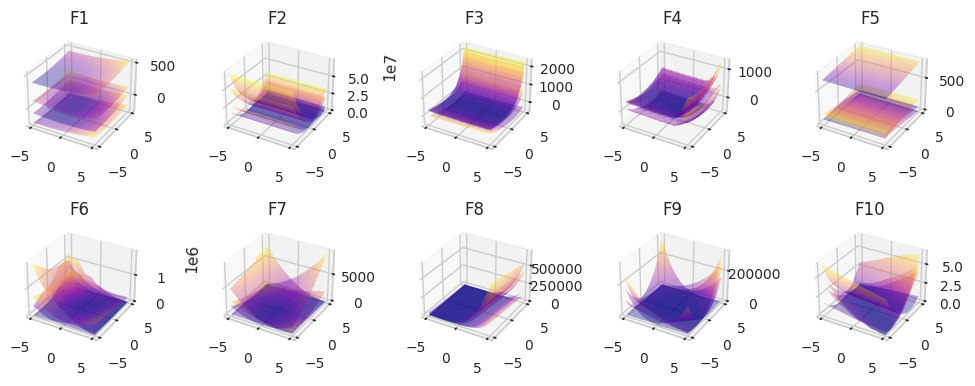

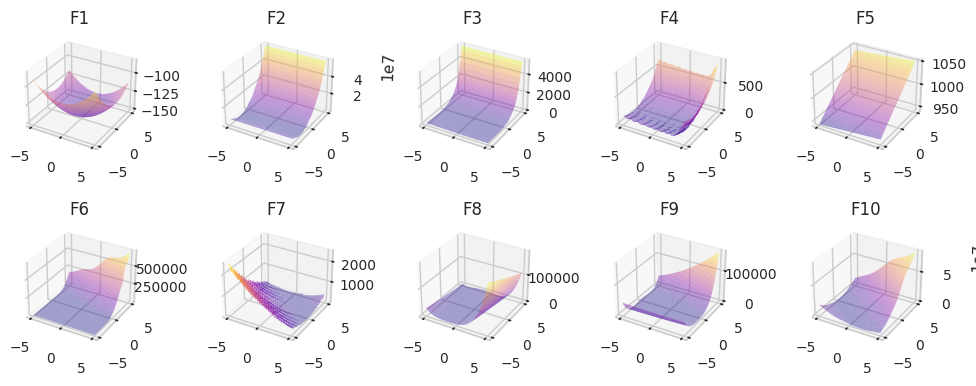

In [3]:
# CMA-ES Train
plot_cma_es(df, "full", "train")
plot_cma_es(df, "full", "test")

In [4]:
# for gid, gdf in df.groupby("source"):
#     print(gid)
#     plot_cma_es(gdf, "selector", "train")

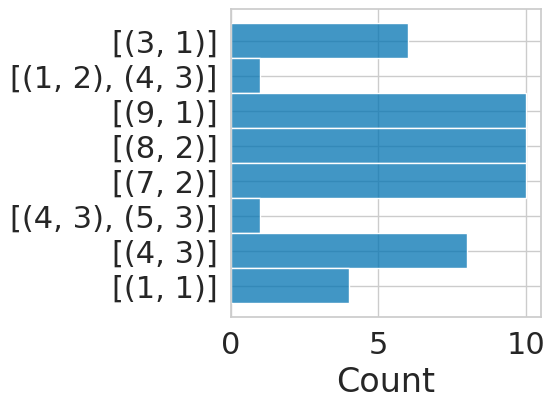

In [5]:
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_palette("colorblind")
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

combos = df[df["origin"] == "selector"].groupby("source").apply(lambda x: str(list(zip(x["fid"], x["iid"]))))

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax = sns.histplot(y=combos.values, ax=ax)
# ax.tick_params(axis='x', labelrotation=90, labelsize=20)
ax.set_xticks([0, 5, 10])
fig.savefig("CMA_selected_instances.pdf", bbox_inches="tight", dpi=300)